# Appendix A code

This appendix is designed to equip you with the necessary skills and knowledge to put deep learning into practice and implement large language models (LLMs) from scratch.

In [63]:
from typing import Tuple

import torch
from torch import Tensor

print(torch.__version__)

2.9.0


In [29]:
import torch

print(f"Torch version: {torch.__version__}",)
print(f"Torch MPS Available: {torch.mps.is_available()}")
print(f"Torch Cuda Available: {torch.cuda.is_available()}")
print(f"Torch device: {torch.device('mps')}")
print(f"Torch device count: {torch.cuda.device_count()}")


Torch version: 2.9.0
Torch MPS Available: True
Torch Cuda Available: False
Torch device: mps
Torch device count: 0


## Understanding tensors
### Scalars, vectors, matrices, and tensors

In [30]:
import torch

tensor0d = torch.tensor(1)
tensor1d = torch.tensor([1, 2, 3])
tensor2d = torch.tensor([[1, 2], [3, 4]])

tensor3d = torch.tensor([[[1, 2], [3, 4]],[[5, 6], [7, 8]]])

print(f"tensor0d Creates a zero-dimensional tensor (scalar) from a Python integer:\n{tensor0d}")
print(f"tensor1d Creates a one-dimensional tensor (vector) from a Python list: \n {tensor1d}")
print(f"tensor2d Creates a two-dimensional tensor (matrix) from a Python list of lists :\n {tensor2d}")
print(f"tensor3d Creates a three-dimensional tensor (tensor) from a Python list of lists of lists\n : {tensor3d}")

tensor0d Creates a zero-dimensional tensor (scalar) from a Python integer:
1
tensor1d Creates a one-dimensional tensor (vector) from a Python list: 
 tensor([1, 2, 3])
tensor2d Creates a two-dimensional tensor (matrix) from a Python list of lists :
 tensor([[1, 2],
        [3, 4]])
tensor3d Creates a three-dimensional tensor (tensor) from a Python list of lists of lists
 : tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])


### Tensor data types

PyTorch adopts the default 64-bit integer data type from Python. We can access the data type of a tensor via the `.dtype` attribute of a tensor

In [31]:
tensor1d = torch.tensor([1, 2, 3])
print(tensor1d.dtype)

torch.int64


When we create tensors from Python floats, PyTorch creates tensors with a 32-bit precision by default; This choice is primarily due to the balance between precision and computational efficiency. A 32-bit floating-point number offers sufficient precision for most deep learning tasks while consuming less memory and computational resources than a 64-bit floating-point number. Moreover, GPU architectures are optimized for 32-bit computations, and using this data type can significantly speed up model training and inference.

In [32]:
floatvec = torch.tensor([1.0, 2.0, 3.0])

print(floatvec.dtype)

torch.float32


It is possible to change the precision using a tensor’s `.to` method.

In [33]:
floatvec = tensor1d.to(torch.float32)

print(floatvec.dtype)

torch.float32


### Common PyTorch tensor operations

Common PyTorch tensor operations include element-wise arithmetic, indexing, slicing, reshaping, and broadcasting. These operations are fundamental for manipulating tensors and performing computations in deep learning models.


In [34]:
# create new tensors
tensor2d = torch.tensor([[1, 2, 3],
                         [4, 5, 6]])

print(tensor2d)

tensor([[1, 2, 3],
        [4, 5, 6]])


The `.shape` attribute allows us to access the shape of a tensor

In [35]:
print(tensor2d.shape)

torch.Size([2, 3])


We can also use `.reshape` to change the shape of a tensor. Reshaping allows us to rearrange the elements of a tensor into a different shape while keeping the same data. For example, a 2D tensor with shape (2, 3) containing 6 elements can be reshaped into a 1D tensor with shape (6), or a 3D tensor with shape (1, 2, 3). The only requirement is that the total number of elements must remain the same.


In [36]:
print(tensor2d.reshape(3, 2))

tensor([[1, 2],
        [3, 4],
        [5, 6]])


However, note that the more common command for reshaping tensors in PyTorch is `.view()`. The `.view()` method is similar to `.reshape()`, but it does not create a new tensor; instead, it returns a view of the original tensor with the specified shape. This can be more memory-efficient, especially when working with large tensors.

In [37]:
print(tensor2d.view(3, 2))

tensor([[1, 2],
        [3, 4],
        [5, 6]])


we can use `.T` to transpose a tensor, which means flipping it across its diagonal.
> Note that this is not the same as reshaping a tensor, as you can see based on the following result

In [38]:
print(tensor2d.T)

tensor([[1, 4],
        [2, 5],
        [3, 6]])


The common way to multiply two matrices in PyTorch is the `.matmul` method

In [39]:
print(tensor2d.matmul(tensor2d.T))
# we can also use @ operator, which achieves the same thing more compactly.
print(tensor2d @ tensor2d.T)

tensor([[14, 32],
        [32, 77]])
tensor([[14, 32],
        [32, 77]])


## Seeing models as computation graphs

PyTorch’s autograd system provides functions to compute gradients in dynamic computational graphs automatically.

The code in the following listing implements the forward pass (prediction step) of a simple logistic regression classifier, which can be seen as a single-layer neural network. It returns a score between 0 and 1, which is compared to the true class label (0 or 1) when computing the loss.

In [40]:
import torch.nn.functional as F #1

y = torch.tensor([1.0]) # 2
x1 = torch.tensor([1.1]) # 3
w1 = torch.tensor([2.2]) # 4
b = torch.tensor([0.0]) # 5
z = x1 * w1 + b # 6
a = torch.sigmoid(z) #7
loss = F.binary_cross_entropy(a, y) #8

2 → True label $y = 1$

3 → Input Feature $x_1 = 1.1$

4 → Weight $w_1 = 2.2$

5 → Bias $b = 0.0$

6 → Net input $z = x_1 \cdot w_1 + b = 1.1 \cdot 2.2 + 0 = 2.42$

7 → Activation $a = \sigma(z) = \frac{1}{1 + e^{-2.42}} \approx 0.918 $

8 → Loss $L = - \left( y \cdot \log(a) + (1 - y) \cdot \log(1 - a) \right) \approx 0.0855$


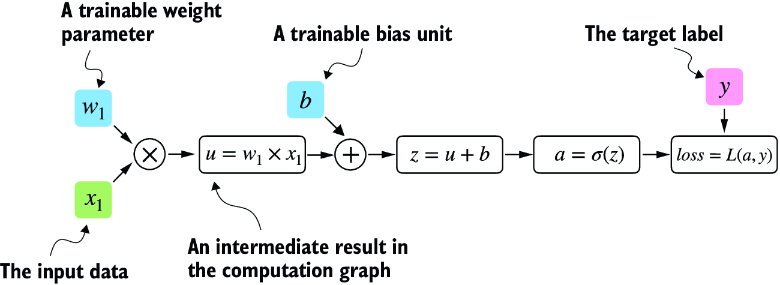
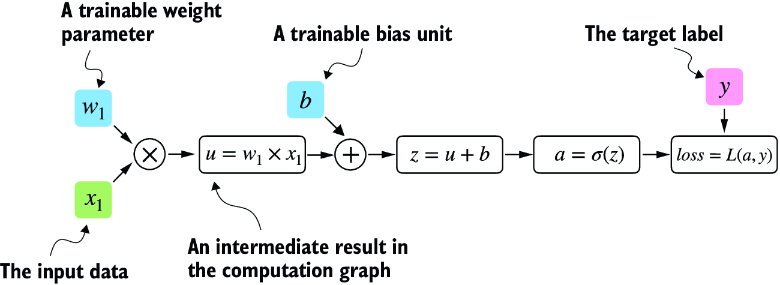

## Automatic differentiation made easy

The most common way of computing the loss gradients in a computation graph involves applying the chain rule from right to left, also called reverse-model automatic differentiation or backpropagation. We start from the output layer (or the loss itself) and work backward through the network to the input layer. We do this to compute the gradient of the loss with respect to each parameter (weights and biases) in the network, which informs how we update these parameters during training.


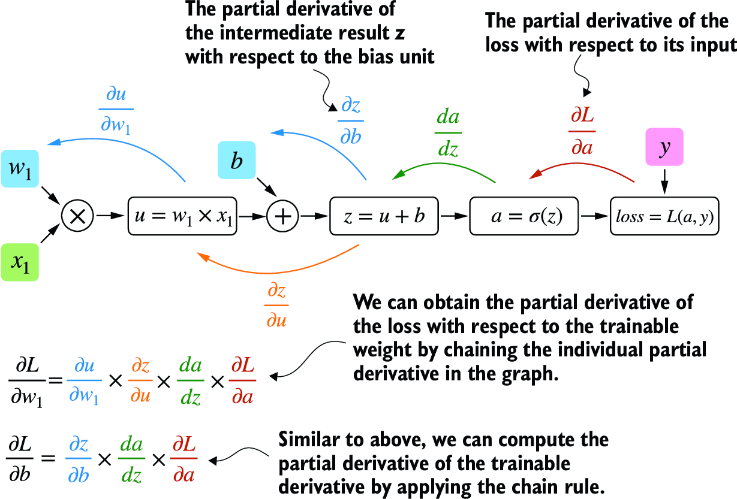

In [41]:
import torch
import torch.nn.functional as F
from torch.autograd import grad

# Inputs and parameters (with gradients enabled)
x = torch.tensor([1.1], requires_grad=False)
w = torch.tensor([2.2], requires_grad=True)   # weight
b = torch.tensor([0.0], requires_grad=True)   # bias

# Forward pass: build computation graph
z = w * x + b        # Linear output
a = torch.sigmoid(z) # Activation
y = torch.tensor([1.0])  # True label

# Compute loss (binary cross entropy)
loss = F.binary_cross_entropy(a, y)

# Compute gradients manually by invoking grad function.
# By default, PyTorch destroys the computation graph after calculating the gradients to free memory. However, since we will reuse this computation graph shortly, we set retain_graph=True so that it stays in memory.
grad_L_w1 = grad(loss, w, retain_graph=True)
grad_L_b = grad(loss, b, retain_graph=True)

print(grad_L_w1)
print(grad_L_b)

(tensor([-0.0898]),)
(tensor([-0.0817]),)


In [42]:
# Backward pass: compute gradients
loss.backward()
# Print gradients
print(w.grad)
print(b.grad)

tensor([-0.0898])
tensor([-0.0817])


### Computation Graph (what PyTorch builds internally)

#### What Happens in `.backward()`

1.	Computes $$\frac{\partial \text{Loss}}{\partial a} \quad \text{(how loss changes with output)}$$
2.	Then backpropagates through sigmoid: $$ \frac{\partial \text{Loss}}{\partial z} = \frac{\partial \text{Loss}}{\partial a} \cdot \frac{\partial a}{\partial z}\quad \text{(chain rule)}$$
3.	Then through z = wx + b:
    * $\frac{\partial z}{\partial w} = x$
    * $\frac{\partial z}{\partial b} = 1$
4. So:
$$\frac{\partial \text{Loss}}{\partial w} = \frac{\partial \text{Loss}}{\partial z} \cdot x$$
$$\frac{\partial \text{Loss}}{\partial b} = \frac{\partial \text{Loss}}{\partial z}$$

## Implementing multilayer neural networks

Let’s look at a multilayer perceptron, a fully connected neural network, as illustrated in the following figure:

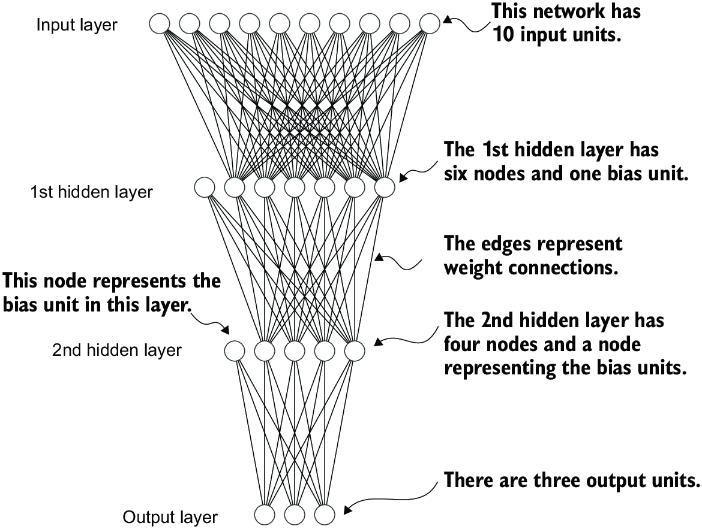

we can subclass the `torch.nn.Module` class to define our own custom network architecture. This Module base class provides a lot of functionality, making it easier to build and train models

<llm-snippet-file>code.ipynb</llm-snippet-file>


In [43]:
class NeuralNetwork(torch.nn.Module):
    """
    A simple feedforward neural network with two hidden layers.
    
    This network implements a standard multilayer perceptron (MLP) architecture
    with ReLU activation functions between layers. The network transforms input
    features through two hidden layers before producing output logits.
    
    Architecture:
        Input Layer -> Hidden Layer 1 (30 units) -> ReLU
        -> Hidden Layer 2 (20 units) -> ReLU
        -> Output Layer (num_outputs units)
    
    Example:
        >>> import torch
        >>> # Create a network for binary classification with 5 input features
        >>> model = NeuralNetwork(num_inputs=5, num_outputs=2)
        >>> 
        >>> # Example input: batch of 3 samples, each with 5 features
        >>> x = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0],
        ...                   [0.5, 1.5, 2.5, 3.5, 4.5],
        ...                   [2.0, 3.0, 4.0, 5.0, 6.0]])
        >>> 
        >>> # Forward pass
        >>> logits = model(x)
        >>> # Output shape: torch.Size([3, 2])
        >>> # Example output: tensor([[-0.234, 0.567],
        ...                            [-0.123, 0.456],
        ...                            [-0.345, 0.678]], grad_fn=<AddmmBackward0>)
    
    Args:
        num_inputs (int): Number of input features
        num_outputs (int): Number of output classes or values
    
    Returns:
        torch.Tensor: Logits of shape (batch_size, num_outputs)
    """

    def __init__(self, num_inputs: int, num_outputs: int) -> None:
        """
        Initialize the neural network layers.
        
        Args:
            num_inputs (int): Number of input features
            num_outputs (int): Number of output classes or values
        """
        super().__init__()
        self.layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_inputs, 30),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(20, num_outputs),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_inputs)
        
        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_outputs)
        """
        logits = self.layers(x)
        return logits


1. Coding the number of inputs and outputs as variables allows us to reuse the same code for datasets with different numbers of features and classes
2. The Linear layer takes the number of input and output nodes as arguments.
3. Nonlinear activation functions are placed between the hidden layers.
4. The number of output nodes of one hidden layer has to match the number of inputs of the next layer.
5. The outputs of the last layer are called logits.

We can then instantiate a new neural network object as follows:

In [44]:
model = NeuralNetwork(50, 3)
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)


Next, let’s check the total number of trainable parameters of this model:

In [45]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable model parameters:", num_params)

Total number of trainable model parameters: 2213


These trainable parameters are contained in the `torch.nn.Linear` layers. A Linear layer multiplies the inputs with a weight matrix and adds a bias vector. This is sometimes referred to as a feedforward or fully connected layer.

We can access the corresponding weight parameter matrix for the first Linear layer  at index position 0 as follows

In [46]:
print(model.layers[0].weight)

Parameter containing:
tensor([[ 0.0037,  0.0560, -0.0131,  ...,  0.0064, -0.0599, -0.0675],
        [ 0.1306,  0.0064, -0.0993,  ...,  0.0128, -0.0708, -0.1067],
        [-0.0519,  0.0322,  0.1082,  ...,  0.0730,  0.1322,  0.1378],
        ...,
        [ 0.0190, -0.0893,  0.1222,  ...,  0.0478,  0.0466,  0.0972],
        [ 0.1268,  0.0739, -0.0833,  ..., -0.0758,  0.0085,  0.1151],
        [ 0.1117, -0.0661, -0.0107,  ...,  0.0182, -0.0794,  0.0024]],
       requires_grad=True)


Let’s use the `.shape` attribute to show its dimensions

In [47]:
print(model.layers[0].weight.shape)

# Similarly, you could access the bias vector via model.layers[0].bias
print(model.layers[0].bias)


torch.Size([30, 50])
Parameter containing:
tensor([-0.0551, -0.1071, -0.0395,  0.0402, -0.0003, -0.0105, -0.1127, -0.0698,
        -0.0746,  0.1202, -0.0049,  0.1232,  0.0946, -0.0935,  0.1021, -0.0486,
        -0.1232, -0.0281,  0.0497, -0.0635, -0.1221,  0.0235, -0.0874, -0.0976,
        -0.1068, -0.0370, -0.0869, -0.1412,  0.1209,  0.0065],
       requires_grad=True)


we want to keep using small random numbers as initial values for our layer weights, we can make the random number initialization reproducible by seeding PyTorch’s random number generator via `manual_seed`

In [48]:
torch.manual_seed(123)
# now lets redefine the model
model = NeuralNetwork(50,3)
print(model.layers[0].weight)

Parameter containing:
tensor([[-0.0577,  0.0047, -0.0702,  ...,  0.0222,  0.1260,  0.0865],
        [ 0.0502,  0.0307,  0.0333,  ...,  0.0951,  0.1134, -0.0297],
        [ 0.1077, -0.1108,  0.0122,  ...,  0.0108, -0.1049, -0.1063],
        ...,
        [-0.0787,  0.1259,  0.0803,  ...,  0.1218,  0.1303, -0.1351],
        [ 0.1359,  0.0175, -0.0673,  ...,  0.0674,  0.0676,  0.1058],
        [ 0.0790,  0.1343, -0.0293,  ...,  0.0344, -0.0971, -0.0509]],
       requires_grad=True)


Now, let’s briefly see how it’s used via the forward pass:

In [49]:
X = torch.rand((1,50)) # create 50-dimensional feature vectors
out = model(X) #automatically execute the forward pass of the model
print(out)

tensor([[-0.1670,  0.1001, -0.1219]], grad_fn=<AddmmBackward0>)


These three numbers correspond to scores (logits) assigned to each of the three output nodes. The output tensor includes a `grad_fn` value, which represents the last operation used to compute the tensor in the computational graph. Specifically, `grad_fn=<AddmmBackward0>` indicates the tensor was created via matrix multiplication (matmul) and addition (add) operations - the "mm" stands for matrix multiplication and "Backward" indicates this operation supports backpropagation.

PyTorch uses this `grad_fn` information to automatically compute gradients during backpropagation by traversing the computational graph in reverse order. Each tensor in the graph stores a reference to the function that created it, forming a chain of operations that can be traced back to the model's parameters. This is the core mechanism behind PyTorch's automatic differentiation system.

When using the model for prediction after training (inference mode), constructing this computational graph is wasteful because:
1. **Memory overhead**: The graph stores intermediate tensors and operations needed for backpropagation
2. **Computational overhead**: Additional bookkeeping operations are performed to track gradients
3. **No training needed**: Gradients are only required during training, not during inference

To disable gradient computation during prediction, wrap the forward pass in a `torch.no_grad()` context manager:




In [50]:
with torch.no_grad():
    out = model(X)

# grad_fn will be None, no computational graph is built
print(out)

tensor([[-0.1670,  0.1001, -0.1219]])


This prevents PyTorch from building the computational graph, saving memory and computation time.

It i common to write models in a way that return the raw output of the last layer, without passing them through the non-linear activation function, because Pytorch commonly used loss functions combine softmax (sigmoid for binary classifications) and a nigative log likelihood loss in a single class, which is more efficient than applying softmax and then computing the loss separately.

if we want to compute we have to call the function explicitly

In [51]:
with torch.no_grad():
    out = torch.softmax(model(X), dim=1)

print(out)

tensor([[0.2983, 0.3896, 0.3121]])


## Setting up efficient data loaders

* Create a custom dataset class
* Using this dataset class creates two dataset objects: one for training and one for testing
* each dataset object has fed to its own Dataloader
* Dataloader is a class that loads data from a dataset and provides an iterable over the data. it is responsible for batching the data, shuffling it, and providing single- or multi-process iterators over the data.


In [57]:
# five training examples with two features each
X_train = torch.tensor([
    [-1.2, 3.1],
    [-0.9, 2.9],
    [-0.5, 2.6],
    [2.3, -1.1],
    [2.7, -1.5]
])
# expected labels
y_train = torch.tensor([0,0,0,1,1])
# two test examples with two features each
X_test = torch.tensor([
    [-0.8, 2.8],
    [2.6, -1.6],
])
# expected labels
y_test = torch.tensor([0,1])

> NOTE PyTorch requires that class labels start with label 0, and the largest class label value should not exceed the number of output nodes minus-1 . So, if we have class labels 0, 1, 2, 3, and 4, the neural network output layer should consist of five nodes.

Next, we create a custom dataset class, ToyDataset, by subclassing from PyTorch’s Dataset

In [58]:
from torch.utils.data import Dataset

class ToyDataset(Dataset):
    def __init__(self, X: Tensor, y: Tensor) -> None:
        self.features = X
        self.labels = y

    def __getitem__(self, item: int) -> Tuple[Tensor, Tensor]:
        """
         Instructions for retrieving exactly one data record and the corresponding label
        :param item:
        :return: tuple of feature vector and label
        """
        return self.features[item], self.labels[item]

    def __len__(self)-> int:
        """
        Instructions for returning the total length of the dataset
        :return:  total length of the dataset
        """
        return self.labels.shape[0]

train_ds = ToyDataset(X_train, y_train)
test_ds = ToyDataset(X_test, y_test)

In [60]:
print(len(train_ds))

5


We set up attributes that we can access later in the `__getitem__` and `__len__` methods. These could be file paths, file objects, database connectors, and so on. these methods are then used by the dataloader to retrieve data records and labels for training and testing and provide the index for the dataset items.

Now, we can use PyTorch’s DataLoader class to sample from it

In [61]:
from torch.utils.data import DataLoader

torch.manual_seed(123)

train_loader = DataLoader(
    # The ToyDataset instance created earlier serves as input to the data loader.
    dataset=train_ds,
    #
    batch_size=2,
    # Whether or not to shuffle the data
    shuffle=True,
    # The number of background processes
    num_workers=0,
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=2,
    # here we don't want to shuffle the data
    shuffle=False,
    num_workers=0,
)

After instantiating the training data loader, we can iterate over it.

In [62]:
for idx, (x, y) in enumerate(train_loader):
    print(f"Batch {idx+1}:", x, y)

Batch 1: tensor([[ 2.3000, -1.1000],
        [-0.9000,  2.9000]]) tensor([1, 0])
Batch 2: tensor([[-1.2000,  3.1000],
        [-0.5000,  2.6000]]) tensor([0, 0])
Batch 3: tensor([[ 2.7000, -1.5000]]) tensor([1])


We specified a batch size of 2 here, but the third batch only contains a single example. In practice, having a substantially smaller batch as the last batch in a training epoch can disturb the convergence during training. To prevent this, set `drop_last=True`, which will drop the last batch in each epoch, as shown in the following listing.

In [64]:
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

Now, iterating over the training loader, we can see that the last batch is omitted:

In [65]:
for idx, (x, y) in enumerate(train_loader):
    print(f"Batch {idx+1}:", x, y)

Batch 1: tensor([[-1.2000,  3.1000],
        [-0.5000,  2.6000]]) tensor([0, 0])
Batch 2: tensor([[ 2.3000, -1.1000],
        [-0.9000,  2.9000]]) tensor([1, 0])


Setting `num_workers=0` in the DataLoader. This parameter in PyTorch’s DataLoader function is crucial for parallelizing data loading and preprocessing. When num_workers is set to 0, the data loading will be done in the main process and not in separate worker processes. it can lead to significant slowdowns during training as the main process need to take time to load the data then feed it to the GPU so the GPU can set idle for a while. In contrast, when num_workers is set to a number greater than 0, multiple worker processes are launched to load data in parallel, freeing the main process to focus on training your model and better utilizing the system’s resources.

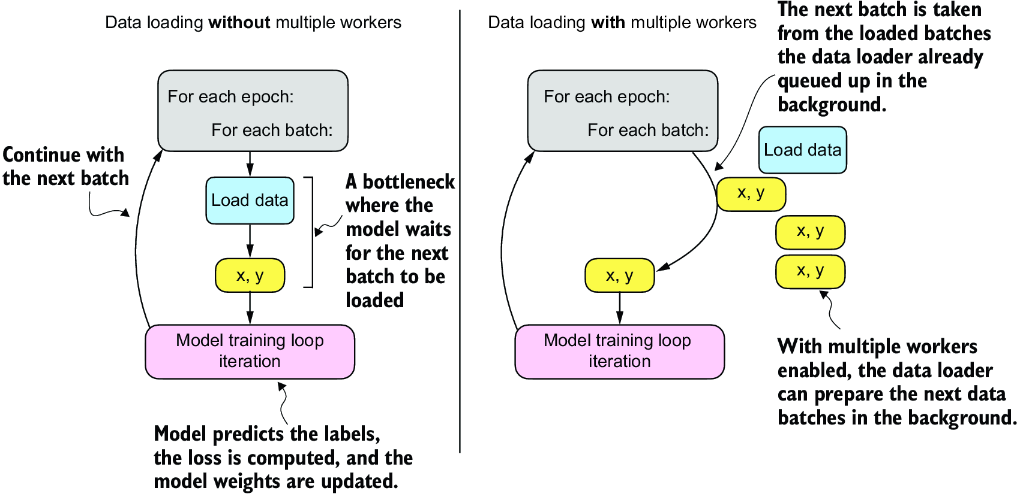

in Jupyter notebooks, setting num_workers to greater than 0 can sometimes lead to problems related to the sharing of resources between different processes. as well as if the dataset is too small then it might actually take longer to spin up workers than loading the actual data. we just need to be mindful of what is the best approach in here.

## A typical training loop

Let’s now train a neural network on the toy dataset. The following listing shows the training code.

In [74]:
torch.manual_seed(123)

model = NeuralNetwork( num_inputs= 2, num_outputs= 2)
# The optimizer needs to know which parameters to optimize.
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

num_epochs = 3
for epoch in range(0,num_epochs):
    # Training loop
    model.train()
    for batch_idx, (features, labels) in enumerate( train_loader):
        #
        logits = model(features)
        # Compute loss and backpropagate
        loss = F.cross_entropy(logits, labels)
        # Sets the gradients from the previous round to 0 to prevent unintended gradient accumulation
        optimizer.zero_grad()
        # Computes the gradients of the loss given the model parameters
        #
        loss.backward()
        # The optimizer uses the gradients to update the model parameters.
        optimizer.step()
        ### LOGGING
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
              f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
              f" | Train Loss: {loss:.2f}")

model.eval()
# Insert optional model evaluation code

Epoch: 001/003 | Batch 000/002 | Train Loss: 0.75
Epoch: 001/003 | Batch 001/002 | Train Loss: 0.50
Epoch: 002/003 | Batch 000/002 | Train Loss: 0.60
Epoch: 002/003 | Batch 001/002 | Train Loss: 0.01
Epoch: 003/003 | Batch 000/002 | Train Loss: 0.17
Epoch: 003/003 | Batch 001/002 | Train Loss: 0.00


NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

because our toy dataset has two input features and two class labels to predict. We used a stochastic gradient descent (SGD) optimizer with a learning rate (lr) of 0.5. The learning rate is a hyperparameter, meaning it's a tunable setting that we must experiment with based on observing the loss. Ideally, we want to choose a learning rate such that the loss converges after a certain number of epochs—the number of epochs is another hyperparameter to choose.

for more information about gradient descent, check the notebook [02_gradient-descent.ipynb](02_gradient-descent.ipynb)

In [71]:
# Exercise 3: How many parameters does the neural network introduced in listing A.9 have?
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total number of trainable model parameters:", num_params)

Total number of trainable model parameters: 752


Now we have trained the model, it's time to test it

In [78]:
model.eval()

with torch.no_grad():
    outputs = model(X_train)
print(outputs)

tensor([[  4.4007, -10.1833],
        [  3.9305,  -9.0995],
        [  3.2686,  -7.5747],
        [ -0.8581,   0.8238],
        [ -1.0269,   0.9832]])


To obtain the class membership probabilities, we can then use PyTorch’s softmax function:

In [79]:
torch.set_printoptions(sci_mode=False)

probas = torch.softmax(outputs, dim=1)

print(probas)

tensor([[1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [0.1568, 0.8432],
        [0.1181, 0.8819]])
